In [20]:
import uproot4
import coffea
%pylab inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import mplhep
plt.style.use(mplhep.style.CMS)

from coffea import hist, processor
from coffea.analysis_objects import JaggedCandidateArray


Populating the interactive namespace from numpy and matplotlib


/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['hist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [92]:
class MyProcessor(processor.ProcessorABC):
    def __init__(self, flag=False):
        self._flag = flag
        self._accumulator = processor.dict_accumulator({
            "sumw": processor.defaultdict_accumulator(float),
            
            "Photons":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("leading_photon_pt","Leading Photon $P_T$",50,0,500),
            hist.Bin("trailing_photon_pt","Trailing Photon $P_T$",50,0,500),
            hist.Bin("leading_photon_eta","Leading Photon $\eta$",10,-2.5,2.5),
            hist.Bin("trailing_photon_eta","Trailing Photon $\eta$",10,-2.5,2.5)),
            
            "diphoton_mass":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("diphoton_mass","Diphoton mass",500,0,500)),
            
            "Taus":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("tau_category","Tau Category",3,1,4),
            hist.Bin("leading_tau_pt","Leading  $\tau P_T$",50,0,500),
            hist.Bin("trailing_tau_pt","Trailing $\tau P_T$",50,0,500),
            hist.Bin("leading_tau_eta","Leading $\tau \eta$",10,-2.5,2.5),
            hist.Bin("trailing_tau_eta","Trailing $\tau \eta$",10,-2.5,2.5)
            ),
            
            "ditau_mass":hist.Hist(
            "Events",
            hist.Cat("dataset","Dataset"),
            hist.Bin("ditau_mass","Ditau mass",500,0,500)),
            
        })

    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        xsecs = {
            "GJets40100":20790,
            "GJets100200":9238,
            "GJets200400":2305,
            "GJets400600":274.4,
            "GJets600Inf":93.46,
            "DYJets":6104,
            "ZGToLLG":117.864,
            "DiPhoton":88.36,
            "signal":0.089
        }
        lumi = 137.2
        output = self.accumulator.identity()
        dataset = df["dataset"]
        
        cut = (df["passedDigammaPair"] == True) & (df["Category_pairs"] >= 1) & (df["nTau"] >= 2) & (df["nPhoton"] >= 2)
        
        #JaggedCandidateArray - one array for each object
        
        photons = JaggedCandidateArray.candidatesfromcounts(
            counts = df["nPhoton"][cut],
            pt = df["Photon_pt"][cut].content,
            eta = df["Photon_eta"][cut].content,
            phi = df["Photon_phi"][cut].content,
            mass = df["Photon_mass"][cut].content,
        )
        
        taus = JaggedCandidateArray.candidatesfromcounts(
        counts = df["nTau"][cut],
        pt = df["Tau_pt"][cut].content,
        eta = df["Tau_eta"][cut].content,
        phi = df["Tau_phi"][cut].content,
        mass = df["Tau_mass"][cut].content,
        )
        
        gHidx = df["gHidx"][cut]
        tauHidx = df["tauHidx"][cut]
        mgg = df["ggMass"][cut]
        mtautau = df["tautauMass"][cut]
        
        #leading_photon_pt = np.array([photons.pt[n,i] for n,i in enumerate(gHidx[:,0])])
        #trailing_photon_pt = np.array([photons.pt[n,i] for n,i in enumerate(gHidx[:,1])])
        #leading_photon_eta = np.array([photons.eta[n,i] for n,i in enumerate(gHidx[:,0])])
        #trailing_photon_eta = np.array([photons.eta[n,i] for n,i in enumerate(gHidx[:,1])])
        
        output["sumw"][dataset] += sum(df["genWeight"])
        photon_pt = photons.pt[gHidx]
        photon_eta = photons.eta[gHidx]
        leading_photon_pt = photon_pt[:,0]
        leading_photon_eta = photon_eta[:,0]
        trailing_photon_pt = photon_pt[:,1]
        trailing_photon_eta = photon_eta[:,1]
       
        try:
            leading_tau_pt = taus.pt[tauHidx][:,0]
            trailing_tau_pt = taus.pt[tauHidx][:,1]
            leading_tau_eta = taus.eta[tauHidx][:,0]
            trailing_tau_eta = taus.pt[tauHidx][:,1]
            
                   output["Taus"].fill(
        dataset = dataset,
        tau_category = df["Category_pairs"][cut],
        leading_tau_pt = leading_tau_pt,
        trailing_tau_pt = trailing_tau_pt,
        leading_tau_eta = leading_tau_eta,
        trailing_tau_eta = trailing_tau_eta,
        weight = df["genWeight"][cut] * xsecs[dataset] * 1000 * lumi
        )
        except:
            pass
            
          
        
        output["Photons"].fill(
        dataset = dataset,
        leading_photon_pt = leading_photon_pt,
        trailing_photon_pt = trailing_photon_pt,
        leading_photon_eta = leading_photon_eta,
        trailing_photon_eta = trailing_photon_eta,
        weight = df["genWeight"][cut] * xsecs[dataset] * 1000 * lumi)
        
        output["diphoton_mass"].fill(
        dataset = dataset,
        diphoton_mass = mgg,
        weight = df["genWeight"][cut] * xsecs[dataset] * 1000 * lumi)
        
     
        
        output["ditau_mass"].fill(
        dataset = dataset,
        ditau_mass = mtautau,
        weight = df["genWeight"][cut] * xsecs[dataset] * 1000 * lumi)

        return output

    def postprocess(self, accumulator):
        return accumulator

In [93]:
import glob
background_fileset = {
    "GJets40100":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/GJets_HT-40To100_17____v1/*.root"),
    "GJets100200":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/GJets_HT-100To200_17____v1/*.root"),
    "GJets200400":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/GJets_HT-200To400_17____v1/*.root"),
    "GJets400600":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/GJets_HT-400To600_17____v1/*.root"),
    "GJets600Inf":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/GJets_HT-600ToInf_17____v1/*.root"),
    "DYJets":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/DYJetsToLL_M-50_17____v1/*.root"),
    "ZGToLLG":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/ZGToLLG_01J_17____v1/*.root"),
    "DiPhoton":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/DiPhotonJetsBox_MGG-80toInf_17____v1/*.root") 
}

signal_fileset = {
    "signal":glob.glob("/hadoop/cms/store/user/legianni/ProjectMetis/HHggtautau_Era2018_private_prova_vera/*.root"),
}


In [95]:
bg_out = processor.run_uproot_job(
background_fileset,
treename = "Events",
processor_instance = MyProcessor(),
executor = processor.futures_executor,
executor_args={'workers': 4, 'function_args': {'flatten': False}},)

In [96]:
signal_out = processor.run_uproot_job(
signal_fileset,
treename = "Events",
processor_instance = MyProcessor(),
executor = processor.futures_executor,
executor_args={'workers': 4, 'function_args': {'flatten': False}},)

In [97]:
outs = {"signal":signal_out,"backgrounds":bg_out}
mgg_hists = {}
mtautau_hists = {}
leading_gamma_pt_hists = {}
trailing_gamma_pt_hists = {}
leading_gamma_eta_hists = {}
trailing_gamma_eta_hists = {}
leading_tau_pt_hists = {}
trailing_tau_pt_hists = {}
leading_tau_eta_hists = {}
trailing_tau_eta_hists = {}
for process,out in outs.items():
    sumw = out["sumw"]
    sumw = {key:1.0/value for key,value in sumw.items()}
    mgg_hists[process] = out["diphoton_mass"].copy() #indexing copies reference! You scale the reference and run this cell multiple times you get smaller and smaller values
    mtautau_hists[process] = out["ditau_mass"].copy()
    leading_gamma_pt_hists[process] = out["Photons"].copy().project("dataset","leading_photon_pt")
    trailing_gamma_pt_hists[process] = out["Photons"].copy().project("dataset","trailing_photon_pt")
    leading_tau_pt_hists[process] = out["Taus"].copy().project("dataset","leading_tau_pt")
    trailing_tau_pt_hists[process] = out["Taus"].copy().project("dataset","trailing_tau_pt")
    
    leading_gamma_eta_hists[process] = out["Photons"].copy().project("dataset","leading_photon_eta")
    trailing_gamma_eta_hists[process] = out["Photons"].copy().project("dataset","trailing_photon_eta")
    leading_tau_eta_hists[process] = out["Taus"].copy().project("dataset","leading_tau_eta")
    trailing_tau_eta_hists[process] = out["Taus"].copy().project("dataset","trailing_tau_eta")
    
    mgg_hists[process].scale(sumw, axis = "dataset")
    mtautau_hists[process].scale(sumw, axis = "dataset")
    leading_gamma_pt_hists[process].scale(sumw, axis = "dataset")
    trailing_gamma_pt_hists[process].scale(sumw, axis = "dataset")
    leading_tau_pt_hists[process].scale(sumw, axis = "dataset")
    trailing_tau_pt_hists[process].scale(sumw, axis = "dataset")
    leading_gamma_eta_hists[process].scale(sumw, axis = "dataset")
    trailing_gamma_eta_hists[process].scale(sumw, axis = "dataset")
    leading_tau_eta_hists[process].scale(sumw, axis = "dataset")
    trailing_tau_eta_hists[process].scale(sumw, axis = "dataset")

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


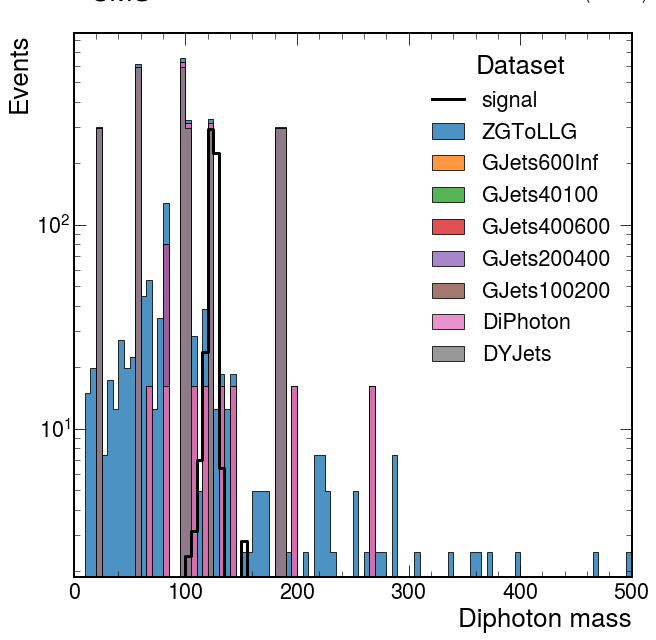

In [98]:
rebin = hist.Bin("diphoton_mass","Diphoton mass",100,0,500)
rebin_tau_mass = hist.Bin("ditau_mass","Ditau mass",100,0,500)
for background,mgg in mgg_hists.items():
    mgg_hists[background] = mgg.rebin("diphoton_mass",rebin)


    
plt.yscale("log")

hist.plot1d(mgg_hists["backgrounds"],overlay = "dataset", stack = True, fill_opts = {
    'alpha': 0.8,
    'edgecolor':(0,0,0,.5)
})

hist.plot1d(mgg_hists["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

plt.savefig("mgg.pdf")

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


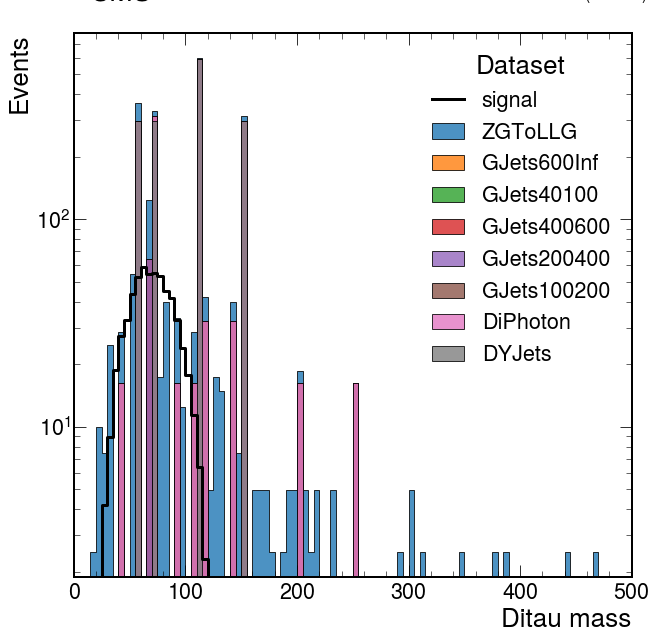

In [99]:
rebin = hist.Bin("ditau_mass","Ditau mass",100,0,500)
for background,mtautau in mtautau_hists.items():
    mtautau_hists[background] = mtautau.rebin("ditau_mass",rebin)    
    
plt.yscale("log")

hist.plot1d(mtautau_hists["backgrounds"],overlay = "dataset", stack = True, fill_opts = {
    'alpha': 0.8,
    'edgecolor':(0,0,0,.5)
})

hist.plot1d(mtautau_hists["signal"], overlay = "dataset", line_opts={'linewidth':3, "color":"black"}
)

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )

plt.savefig("mtautau.pdf")

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


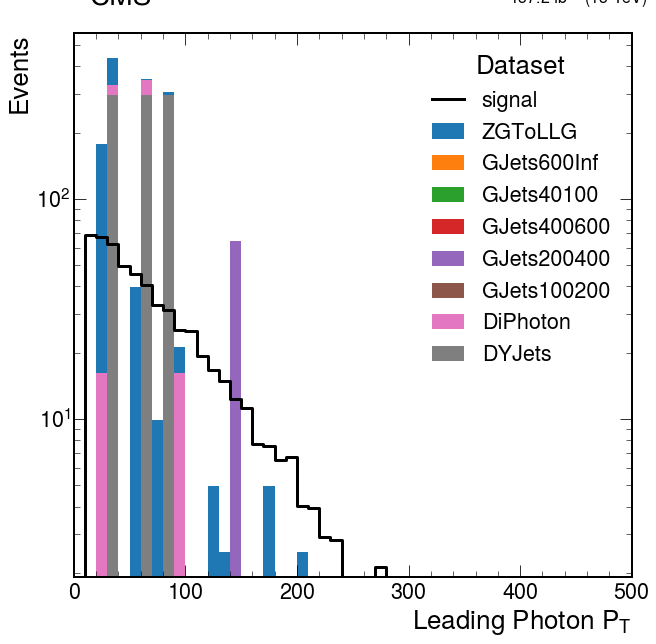

In [100]:
rebin = hist.Bin("lepton_pt","Lepton pt",100,0,500)
plt.yscale("log")

hist.plot1d(leading_gamma_pt_hists["backgrounds"], stack = True)
hist.plot1d(leading_gamma_pt_hists["signal"],line_opts={'linewidth':3, "color":"black"})

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )
plt.savefig("leading_photon_pt.pdf")

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


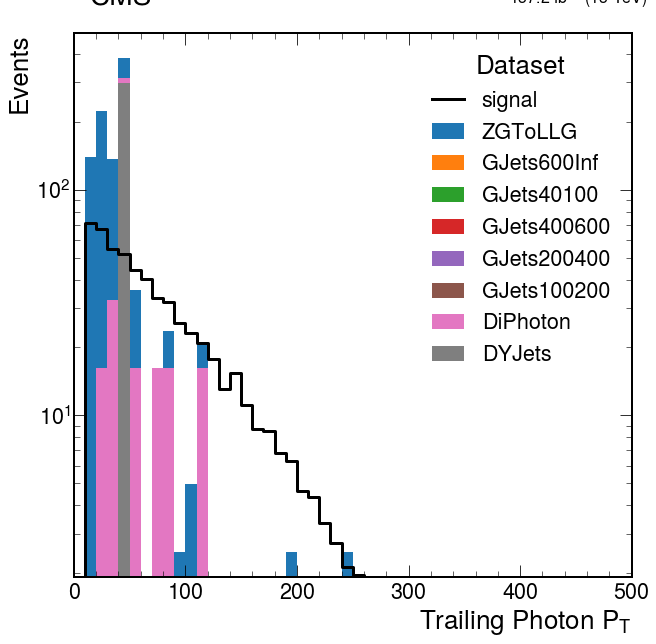

In [101]:
plt.yscale("log")

hist.plot1d(trailing_gamma_pt_hists["backgrounds"], stack = True)
hist.plot1d(trailing_gamma_pt_hists["signal"],line_opts={'linewidth':3, "color":"black"})

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )
plt.savefig("trailing_photon_pt.pdf")

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


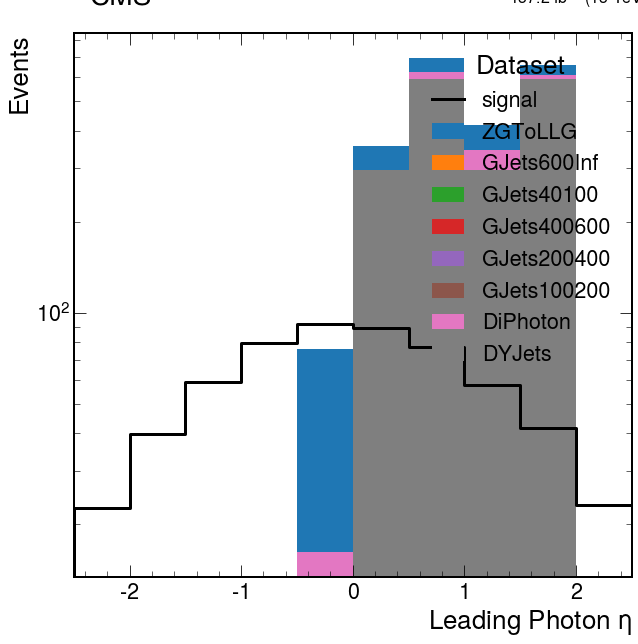

In [102]:
plt.yscale("log")

hist.plot1d(leading_gamma_eta_hists["backgrounds"], stack = True)
hist.plot1d(leading_gamma_eta_hists["signal"],line_opts={'linewidth':3, "color":"black"})

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )
plt.savefig("leading_photon_eta.pdf")

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:280: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, None)
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


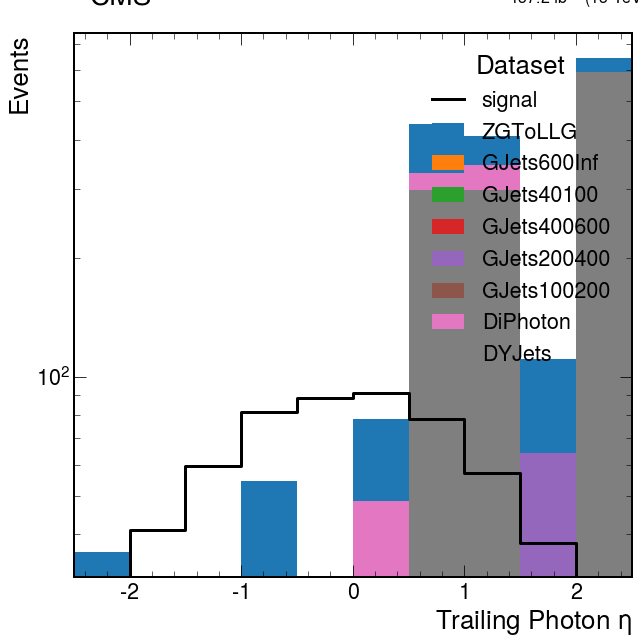

In [103]:
plt.yscale("log")

hist.plot1d(trailing_gamma_eta_hists["backgrounds"], stack = True)
hist.plot1d(trailing_gamma_eta_hists["signal"],line_opts={'linewidth':3, "color":"black"})

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )
plt.savefig("trailing_photon_eta.pdf")

/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'texgyreheros-regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


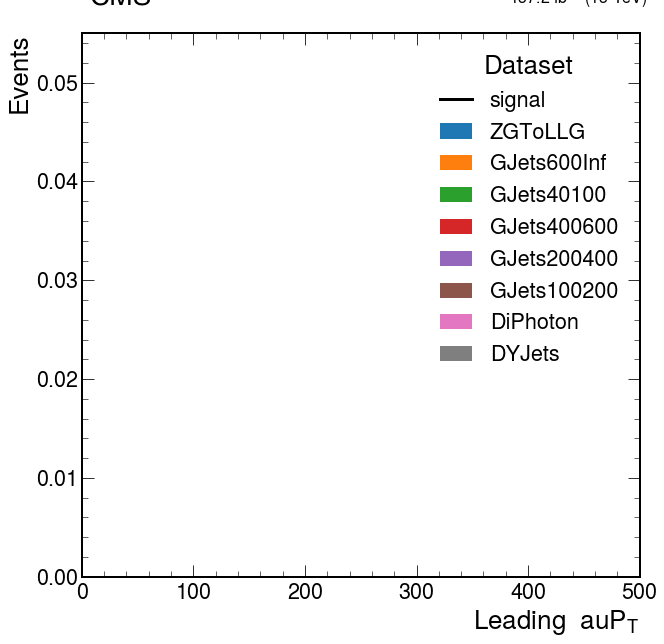

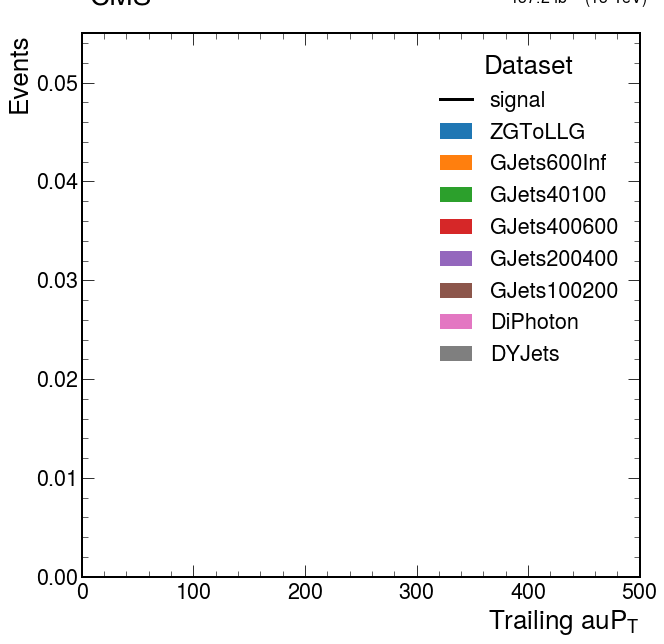

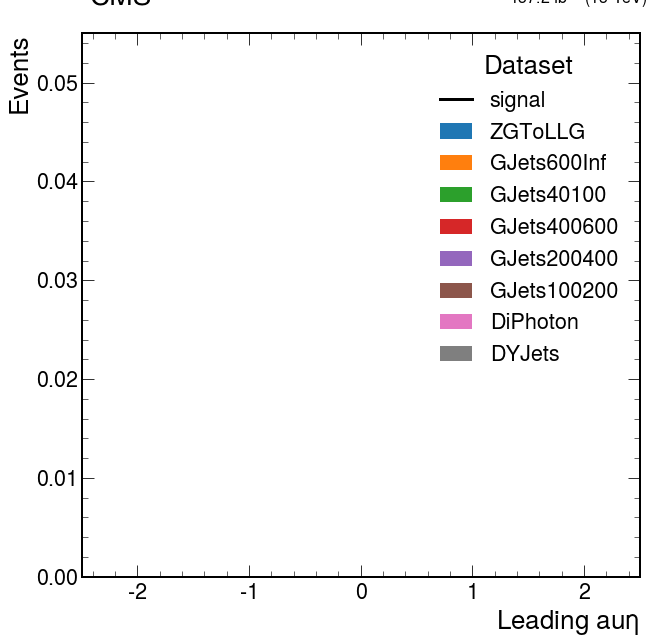

In [104]:
#plt.yscale("log")

hist.plot1d(leading_tau_pt_hists["backgrounds"], stack = True)
hist.plot1d(leading_tau_pt_hists["signal"],line_opts={'linewidth':3, "color":"black"})

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )
plt.savefig("leading_tau_pt.pdf")

plt.figure()
#plt.yscale("log")

hist.plot1d(trailing_tau_pt_hists["backgrounds"], stack = True)
hist.plot1d(trailing_tau_pt_hists["signal"],line_opts={'linewidth':3, "color":"black"})

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )
plt.savefig("trailing_tau_pt.pdf")

plt.figure()
#plt.yscale("log")

hist.plot1d(leading_tau_eta_hists["backgrounds"], stack = True)
hist.plot1d(leading_tau_eta_hists["signal"],line_opts={'linewidth':3, "color":"black"})

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )
plt.savefig("leading_tau_eta.pdf")


/home/users/bsathian/miniconda3/envs/analysisenv/lib/python3.7/site-packages/coffea/hist/plot.py:44: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn("All sumw are zero!  Cannot compute meaningful error bars", RuntimeWarning)


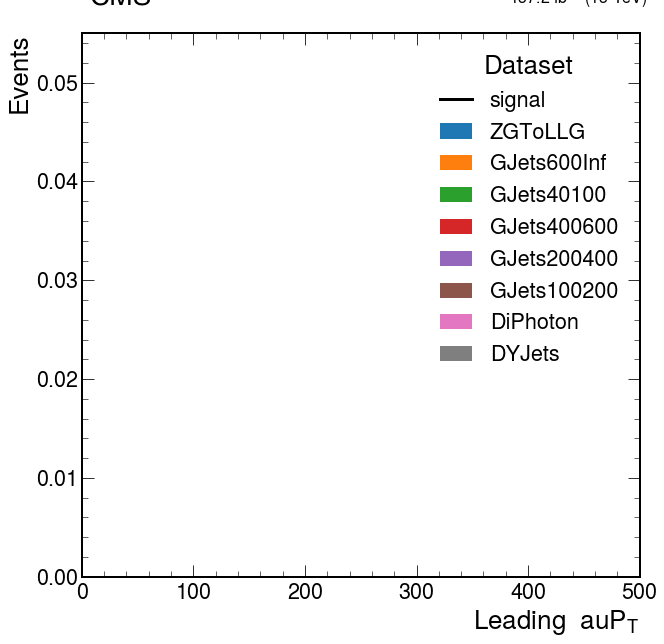

In [105]:
hist.plot1d(leading_tau_pt_hists["backgrounds"], stack = True)
hist.plot1d(leading_tau_pt_hists["signal"],line_opts={'linewidth':3, "color":"black"})

coffee = plt.text(0., 1., "CMS",
                  fontsize=28, 
                  horizontalalignment='left', 
                  verticalalignment='bottom', 
                  transform=ax.transAxes
                 )
lumi = plt.text(1., 1., r"137.2 fb$^{-1}$ (13 TeV)",
                fontsize=16, 
                horizontalalignment='right', 
                verticalalignment='bottom', 
                transform=ax.transAxes
               )